# Imports and Installation

In [ ]:
!pip install xgboost
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier, XGBRegressor, plot_tree
import shap
import graphviz
from sklearn.exceptions import UndefinedMetricWarning
import time
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

start_time = time.time()

# **Preprocessing**

## Data Initialization & Overview

### DATASET
https://www.kaggle.com/datasets/bryanb/fifa-player-stats-database

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bryanb/fifa-player-stats-database
!unzip fifa-player-stats-database.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/bryanb/fifa-player-stats-database
License(s): CC0-1.0
 98% 13.0M/13.3M [00:00<00:00, 53.0MB/s]
100% 13.3M/13.3M [00:00<00:00, 50.5MB/s]
Archive:  fifa-player-stats-database.zip
  inflating: FIFA17_official_data.csv  
  inflating: FIFA18_official_data.csv  
  inflating: FIFA19_official_data.csv  
  inflating: FIFA20_official_data.csv  
  inflating: FIFA21_official_data.csv  
  inflating: FIFA22_official_data.csv  
  inflating: FIFA23_official_data.csv  


### Load the Data

In [ ]:
fifa17 = pd.read_csv('FIFA17_official_data.csv')
fifa18 = pd.read_csv('FIFA18_official_data.csv')
fifa19 = pd.read_csv('FIFA19_official_data.csv')
fifa20 = pd.read_csv('FIFA20_official_data.csv')
fifa21 = pd.read_csv('FIFA21_official_data.csv')
fifa22 = pd.read_csv('FIFA22_official_data.csv')

In [ ]:
fifas = [fifa17, fifa18, fifa19, fifa20, fifa21, fifa22]

### Basic Statistics

In [ ]:
# print all columns of the first row of fifa17 dataframe

fifa17.iloc[0]


ID                                                               176580
Name                                                          L. Suárez
Age                                                                  29
Photo                  https://cdn.sofifa.com/players/176/580/17_60.png
Nationality                                                     Uruguay
                                             ...                       
GKKicking                                                          31.0
GKPositioning                                                      33.0
GKReflexes                                                         37.0
Best Position                                                        ST
Best Overall Rating                                                88.0
Name: 0, Length: 63, dtype: object

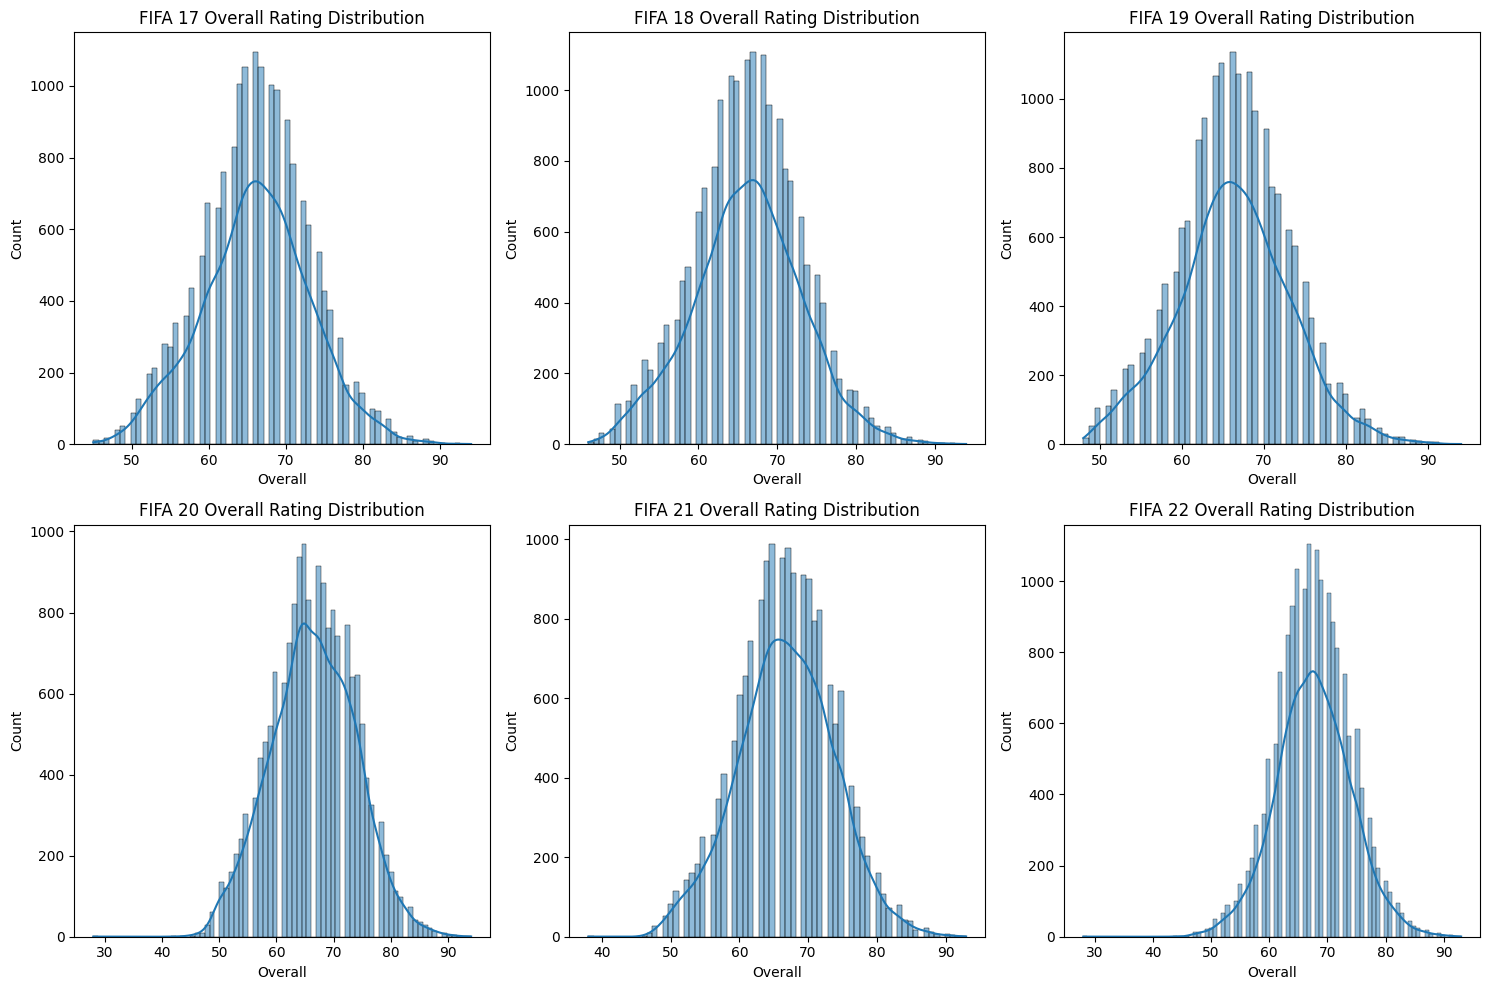

In [ ]:
# plot for all fifa dataframes (17-22) the distribution of the 'overall rating' feature

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, fifa in enumerate(fifas):
  row = i // 3
  col = i % 3
  sns.histplot(fifa['Overall'], ax=axes[row, col], kde=True).set(title=f'FIFA {17 + i} Overall Rating Distribution')

plt.tight_layout()
plt.show()


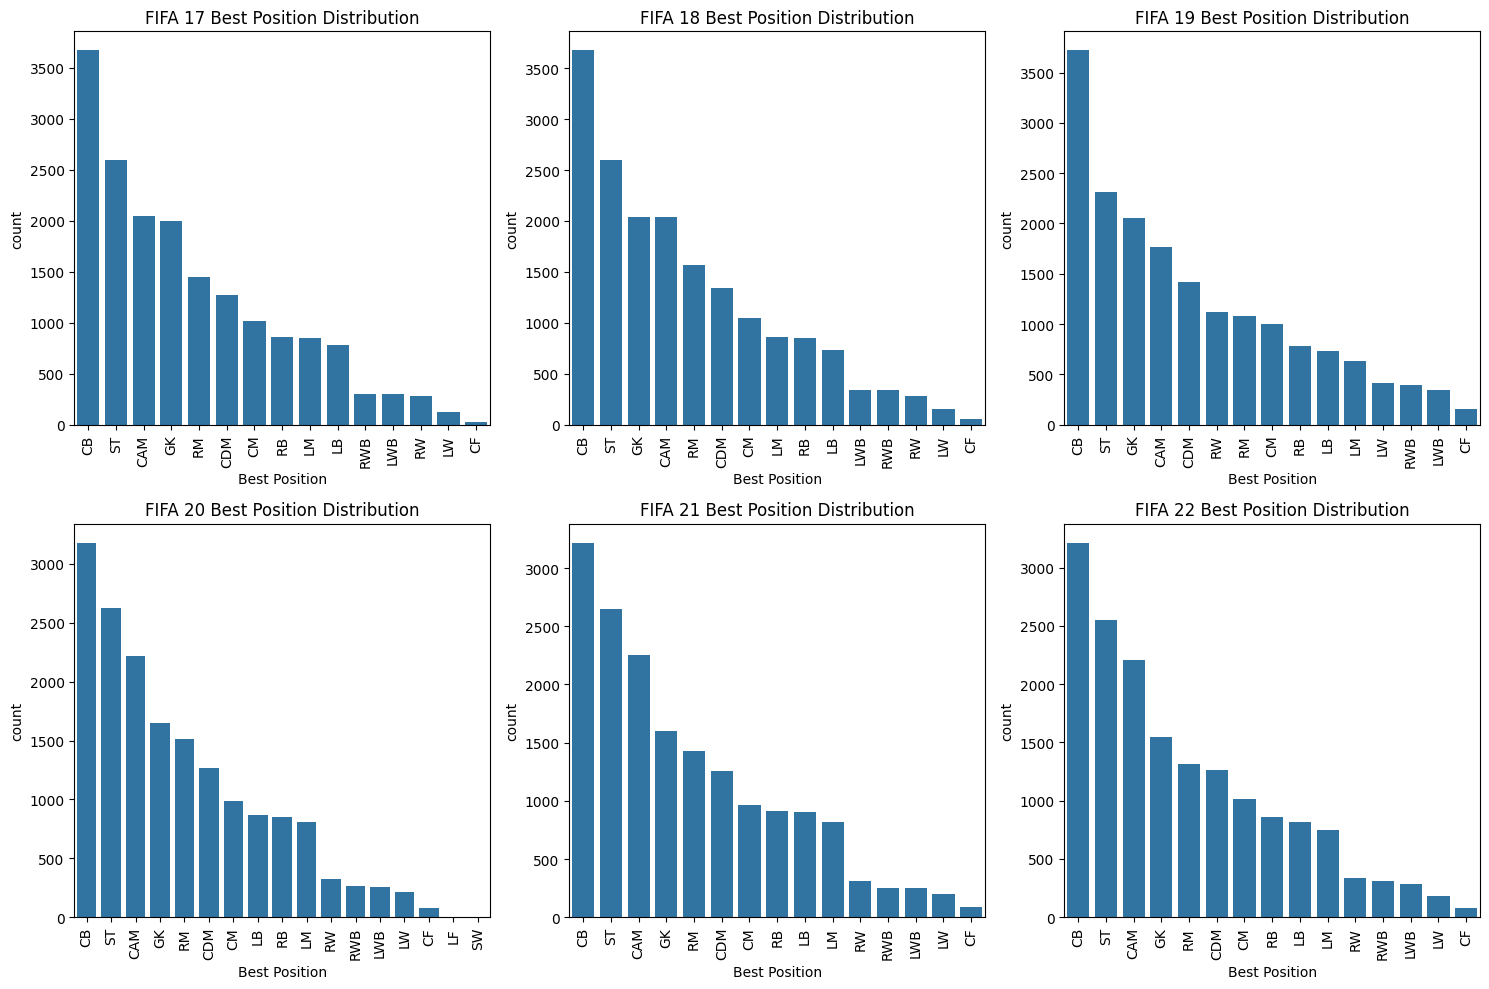

In [ ]:
# plot for all fifa dataframes (17-22) the distribution of the ' best position' categorical feature

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, fifa in enumerate(fifas):
  row = i // 3
  col = i % 3
  sns.countplot(x='Best Position', data=fifa, order=fifa['Best Position'].value_counts().index, ax=axes[row, col]).set(title=f'FIFA {17 + i} Best Position Distribution')
  axes[row, col].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
i = 17
for fifa in fifas:
  rows, cols = fifa.shape
  print(f'FIFA {i} - Number of cols:{cols}')
  print(f'FIFA {i} - Number of rows:{rows}')
  print('_' * 50)
  i += 1

FIFA 17 - Number of cols:63
FIFA 17 - Number of rows:17560
__________________________________________________
FIFA 18 - Number of cols:64
FIFA 18 - Number of rows:17927
__________________________________________________
FIFA 19 - Number of cols:64
FIFA 19 - Number of rows:17943
__________________________________________________
FIFA 20 - Number of cols:65
FIFA 20 - Number of rows:17104
__________________________________________________
FIFA 21 - Number of cols:65
FIFA 21 - Number of rows:17108
__________________________________________________
FIFA 22 - Number of cols:65
FIFA 22 - Number of rows:16710
__________________________________________________


In [ ]:
# Count the number of null values in each column
def show_missing_values(fifas):
  i = 17
  for fifa in fifas:
    null_counts = fifa.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    print(f'FIFA{i} - Null Value Counts:\n', null_counts)
    print('_' * 50)
    i +=1

show_missing_values(fifas)

FIFA17 - Null Value Counts:
 Club                      243
Position                   19
Jersey Number              19
Joined                   1695
Loaned From             16227
Contract Valid Until      362
dtype: int64
__________________________________________________
FIFA18 - Null Value Counts:
 Club                      252
Position                   19
Jersey Number              19
Joined                   1864
Loaned From             16445
Contract Valid Until      382
Release Clause           1748
dtype: int64
__________________________________________________
FIFA19 - Null Value Counts:
 Club                      238
Position                   14
Jersey Number              14
Joined                   1956
Loaned From             16355
Contract Valid Until      368
Release Clause           1841
dtype: int64
__________________________________________________
FIFA20 - Null Value Counts:
 Club                      388
Body Type                  27
Real Face                  27
Po

### Drop Unnecessary Columns



In [ ]:
def clean_fifa_data(df):
    def convert_column_to_int(df, col_name):
        regex = r'\d+'
        lst = []
        for value in df[col_name]:
            match = re.search(regex, value)
            if match:
                number = int(match.group())
                lst.append(number)
            else:
                lst.append(0)  # handle missing values
        df[col_name] = lst

    # Convert columns to integers
    convert_column_to_int(df, "Value")
    convert_column_to_int(df, "Wage")
    convert_column_to_int(df, "Height")
    convert_column_to_int(df, "Weight")

    # Extract the body type from values that contain additional information
    df['Body Type'] = df['Body Type'].str.extract('(Normal|Stocky|Unique|Lean)')

    # Drop unnecessary columns
    columns_to_drop = ['Photo','Flag', 'Club Logo', 'Real Face',
                       'Joined', 'Loaned From', 'Contract Valid Until',
                       'Jersey Number','Release Clause', 'DefensiveAwareness',
                       'Club']

    for column in columns_to_drop:
        if column in df.columns:
            df = df.drop(column, axis=1)

    return df


In [ ]:
fifa17 = clean_fifa_data(fifa17)
fifa18 = clean_fifa_data(fifa18)
fifa19 = clean_fifa_data(fifa19)
fifa20 = clean_fifa_data(fifa20)
fifa21 = clean_fifa_data(fifa21)
fifa22 = clean_fifa_data(fifa22)

In [ ]:
fifas = [fifa17, fifa18, fifa19, fifa20, fifa21, fifa22]

In [ ]:
i = 17
j = 2017
for fifa in fifas:
  rows, cols = fifa.shape
  fifa['Year'] = j
  j += 1
  print(f'FIFA {i} - Number of cols:{cols}')
  print(f'FIFA {i} - Number of rows:{rows}')
  print(30 * '_')
  i += 1

FIFA 17 - Number of cols:54
FIFA 17 - Number of rows:17560
______________________________
FIFA 18 - Number of cols:54
FIFA 18 - Number of rows:17927
______________________________
FIFA 19 - Number of cols:54
FIFA 19 - Number of rows:17943
______________________________
FIFA 20 - Number of cols:54
FIFA 20 - Number of rows:17104
______________________________
FIFA 21 - Number of cols:54
FIFA 21 - Number of rows:17108
______________________________
FIFA 22 - Number of cols:54
FIFA 22 - Number of rows:16710
______________________________


In [ ]:
df_fifa = pd.concat([fifa17, fifa18, fifa19, fifa20, fifa21, fifa22], ignore_index=True)

In [ ]:
df_fifa.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104352 entries, 0 to 104351
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        104352 non-null  int64  
 1   Name                      104352 non-null  object 
 2   Age                       104352 non-null  int64  
 3   Nationality               104352 non-null  object 
 4   Overall                   104352 non-null  int64  
 5   Potential                 104352 non-null  int64  
 6   Value                     104352 non-null  int64  
 7   Wage                      104352 non-null  int64  
 8   Special                   104352 non-null  int64  
 9   Preferred Foot            104352 non-null  object 
 10  International Reputation  104352 non-null  float64
 11  Weak Foot                 104352 non-null  float64
 12  Skill Moves               104352 non-null  float64
 13  Work Rate                 104352 non-null  o

In [ ]:
df_fifa.head(3)

,ID,Name,Age,Nationality,Overall,Potential,Value,Wage,Special,Preferred Foot,...,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Year
0,176580,L. Suárez,29,Uruguay,92,92,83,525,2291,Right,...,45.0,38.0,27.0,25.0,31.0,33.0,37.0,ST,88.0,2017
1,178518,R. Nainggolan,28,Belgium,86,86,37,130,2290,Right,...,85.0,88.0,11.0,11.0,14.0,8.0,11.0,CDM,84.0,2017
2,181872,A. Vidal,29,Chile,87,87,41,180,2285,Right,...,89.0,84.0,4.0,2.0,4.0,2.0,4.0,CDM,85.0,2017


## Visualization for EDA

### EDA Plot 1

**EDA Plot: Preferred Foot of Players in Different Positions**

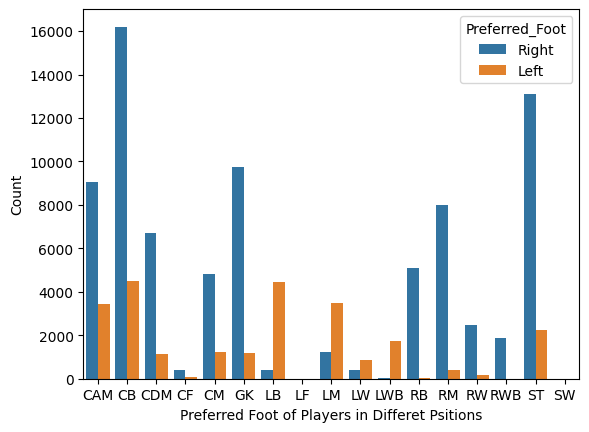

In [ ]:
dft = df_fifa.groupby("Best Position")["Preferred Foot"].value_counts().reset_index(name='Count')
p = sns.barplot(x='Best Position', y='Count', data=dft, hue='Preferred Foot')
p.legend(title='Preferred_Foot')
p.set(xlabel='Preferred Foot of Players in Differet Psitions')
import matplotlib.patches as mpatches

### EDA Plot 2

**EDA Plot: Distribution of Overall Ratings by Position**

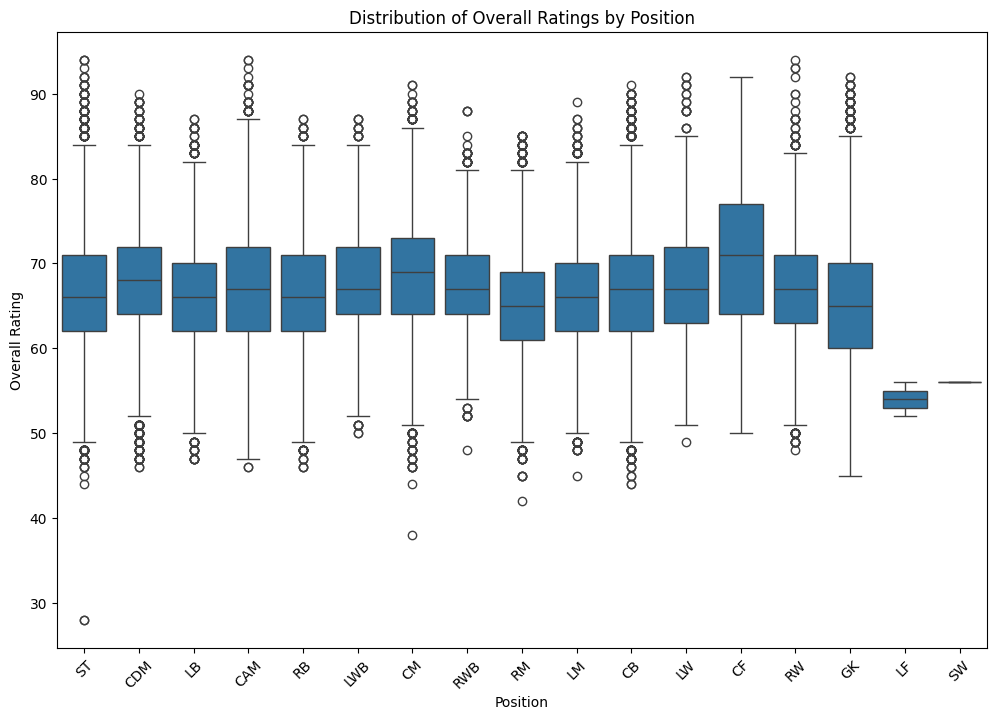

In [ ]:
# Plot: Distribution of Overall Ratings by Position
plt.figure(figsize=(12, 8))
sns.boxplot(x='Best Position', y='Overall', data=df_fifa)
plt.title('Distribution of Overall Ratings by Position')
plt.xlabel('Position')
plt.ylabel('Overall Rating')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calculate the summary statistics for the 'Overall' ratings grouped by 'Best Position'
summary_stats = df_fifa.groupby('Best Position')['Overall'].describe()

# Select the relevant statistics: count, mean, std, min, 25%, 50%, 75%, max
summary_stats = summary_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Reset the index to turn 'Best Position' into a column
summary_stats.reset_index(inplace=True)

# Display the summary statistics
print(summary_stats)

   Best Position    count       mean       std   min   25%   50%   75%   max
0            CAM  12517.0  67.082767  7.358412  46.0  62.0  67.0  72.0  94.0
1             CB  20687.0  66.690724  6.726064  44.0  62.0  67.0  71.0  91.0
2            CDM   7824.0  67.756391  6.579067  46.0  64.0  68.0  72.0  90.0
3             CF    480.0  70.743750  8.454901  50.0  64.0  71.0  77.0  92.0
4             CM   6018.0  68.546361  7.040206  38.0  64.0  69.0  73.0  91.0
5             GK  10890.0  65.240771  7.842025  45.0  60.0  65.0  70.0  92.0
6             LB   4840.0  65.926033  6.532914  47.0  62.0  66.0  70.0  87.0
7             LF      2.0  54.000000  2.828427  52.0  53.0  54.0  55.0  56.0
8             LM   4711.0  66.368924  6.323730  45.0  62.0  66.0  70.0  89.0
9             LW   1279.0  67.295543  6.824555  49.0  63.0  67.0  72.0  92.0
10           LWB   1779.0  67.673974  6.000886  50.0  64.0  67.0  72.0  87.0
11            RB   5116.0  66.266419  6.713606  46.0  62.0  66.0  71.0  87.0

### EDA Plot 3

**EDA Plot: Relationship Between Player Potential and Overall Rating by Age**

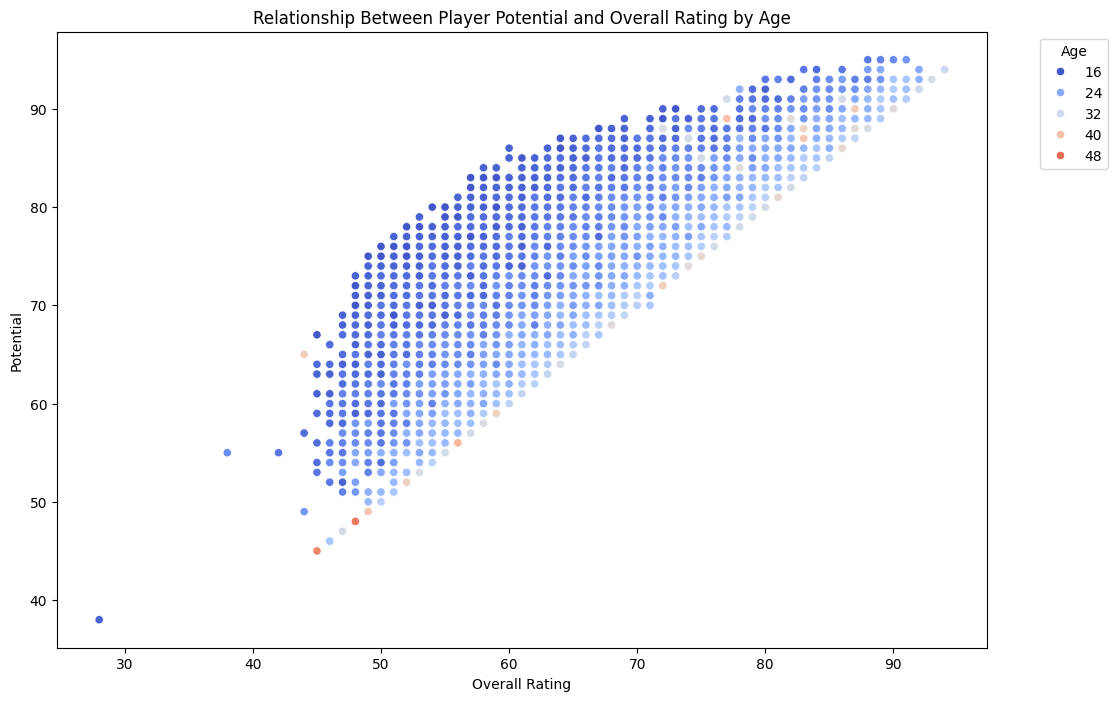

In [ ]:
# Plot: Relationship Between Player Potential and Overall Rating by Age with Contrasted Colors
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Overall', y='Potential', hue='Age', palette='coolwarm', data=df_fifa)
plt.title('Relationship Between Player Potential and Overall Rating by Age')
plt.xlabel('Overall Rating')
plt.ylabel('Potential')
plt.legend(title='Age', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# Calculate summary statistics
summary_stats = df_fifa.groupby('Age').agg({
    'Overall': ['mean', 'std'],
    'Potential': ['mean', 'std']
}).reset_index()

# Calculate correlation between 'Overall' rating and 'Potential'
correlation = df_fifa[['Overall', 'Potential']].corr().iloc[0, 1]

# Display summary statistics
print("Summary Statistics by Age:")
print(summary_stats)

print("\nCorrelation between Overall Rating and Potential:")
print(correlation)


Summary Statistics by Age:
   Age    Overall             Potential           
             mean        std       mean        std
0   15  52.000000   3.207135  71.375000   5.262740
1   16  55.598716   4.981909  74.300161   5.922445
2   17  56.963333   5.283019  74.197083   5.956483
3   18  58.324913   5.493043  73.538088   5.920809
4   19  60.436886   5.799324  73.458550   5.825092
5   20  62.564768   5.932077  73.470861   5.887350
6   21  64.285985   6.070005  73.398990   5.916103
7   22  65.718853   5.929143  73.244882   5.866511
8   23  67.081670   5.911324  72.999478   5.835448
9   24  67.892069   5.750324  72.163472   5.830676
10  25  68.545983   5.743364  71.287236   5.842545
11  26  69.098088   5.717932  70.506618   5.844629
12  27  69.525581   5.707719  70.096673   5.782084
13  28  69.764389   5.696057  69.975597   5.728607
14  29  69.938183   5.597591  70.004146   5.612728
15  30  70.192079   5.619370  70.209461   5.611988
16  31  70.367780   5.598396  70.398251   5.617606
17  

## Handling Missing Values

In [ ]:
null_counts = df_fifa.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_counts

Body Type          222
Position           117
Volleys            115
Curve              115
Agility            115
Balance            115
Jumping            115
Interceptions       15
Positioning         15
Vision             115
Composure          958
Marking          47402
SlidingTackle      115
dtype: int64

In [ ]:
try:
    df_fifa = df_fifa.drop(columns=['Marking'])
    print(f'In our df there is {df_fifa.shape[0]} rows, 47402 null values as seen in column Marking')
    print('it is too much so we decided to drop this column')
except Exception as e:
    print(e)

In our df there is 104352 rows, 47402 null values as seen in column Marking
it is too much so we decided to drop this column


In [ ]:
# We will use the Best Position, this 'Position' is the current position that the player
# is playing ( a player can play in different positions)
df_fifa = df_fifa.dropna(subset=['Position'])

In [ ]:
null_counts = df_fifa.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_counts

Body Type        217
Volleys          104
Curve            104
Agility          104
Balance          104
Jumping          104
Interceptions     15
Positioning       15
Vision           104
Composure        937
SlidingTackle    104
dtype: int64

In [ ]:
def get_mode(series):
    mode = series.mode()
    if len(mode) > 0:
        return mode[0]
    else:
        return None

# Group by 'position' and fill nulls with the mode of each groups 'Body Type'
df_fifa['Body Type'] = df_fifa.groupby('Position')['Body Type'].transform(lambda x: x.fillna(get_mode(x)))

### Data Distribution Histograms

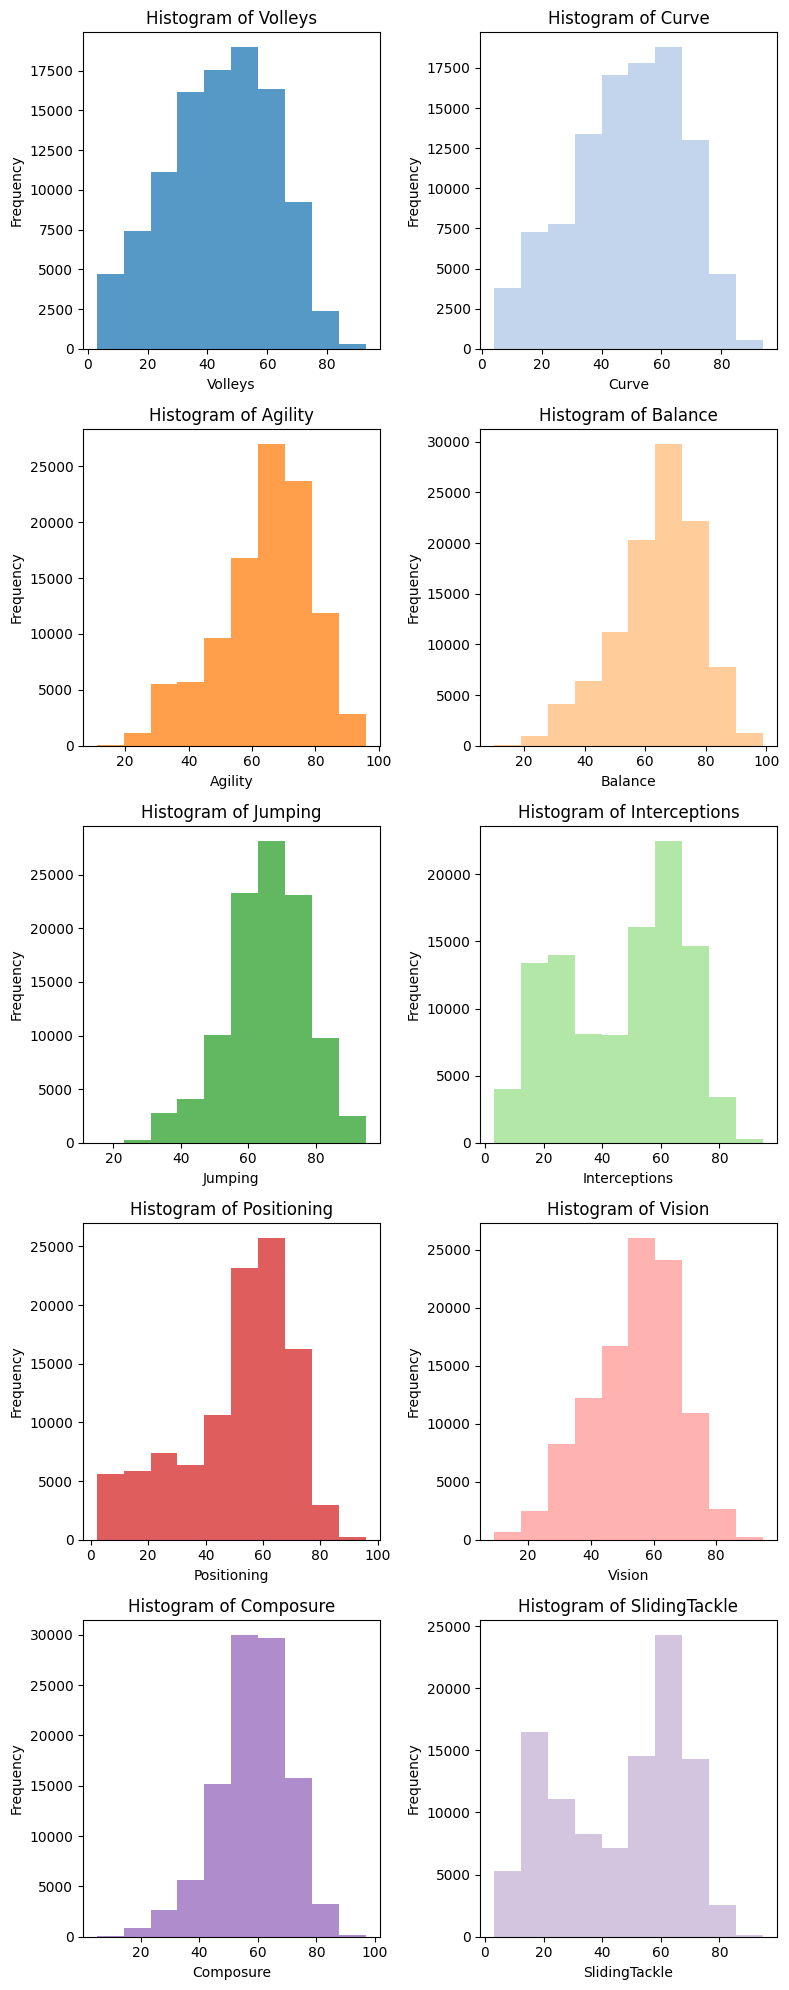

In [ ]:
columns_with_nulls = df_fifa.columns[df_fifa.isnull().any()].tolist()
num_plots_per_row = 2
num_rows = (len(columns_with_nulls) + num_plots_per_row - 1) // num_plots_per_row
fig, axes = plt.subplots(nrows=num_rows, ncols=num_plots_per_row, figsize=(8, 4*num_rows))
colors = plt.cm.tab20.colors
for i, col in enumerate(columns_with_nulls):
    row = i // num_plots_per_row
    col_index = i % num_plots_per_row
    ax = axes[row, col_index]
    ax.hist(df_fifa[col].dropna(), bins=10, alpha=0.75, color=colors[i % len(colors)])
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

for i in range(len(columns_with_nulls), num_rows * num_plots_per_row):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


### KNN Imputer

In [ ]:
def fill_nulls_with_distribution(df, column_name, distribution_type='normal'):
    for index, row in df.iterrows():
        if pd.isnull(row[column_name]):
            position = row['Position']
            position_values = df[df['Position'] == position][column_name].dropna().values

            if len(position_values) > 0:
                if distribution_type == 'normal':
                    mu, std = norm.fit(position_values)
                    sampled_value = norm.rvs(loc=mu, scale=std)
                elif distribution_type == 'skewed':
                    median_value = np.median(position_values)
                    sampled_value = median_value
                elif distribution_type == 'non-normal':
                    sampled_value = np.random.choice(position_values)
                df.at[index, column_name] = sampled_value

def fill_nulls_knn(df, column_name):
    """
    Fill null values using KNN imputer.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to fill null values for.
    """
    imputer = KNNImputer(n_neighbors=5)
    df[[column_name]] = imputer.fit_transform(df[[column_name]])

columns_to_impute = {
    'Volleys': 'skewed',
    'Curve': 'skewed',
    'Agility': 'normal',
    'Balance': 'normal',
    'Jumping': 'normal',
    'Interceptions': 'non-normal',
    'Positioning': 'normal',
    'Vision': 'normal',
    'Composure': 'normal',
    'SlidingTackle': 'non-normal'
}

for column, dist_type in columns_to_impute.items():
    if dist_type == 'non-normal':
        fill_nulls_knn(df_fifa, column)
    else:
        fill_nulls_with_distribution(df_fifa, column, dist_type)


In [ ]:
print(f'Number of Null Valuesl: {df_fifa.isnull().sum().sum()}')
print(f'finished fill null values')

Number of Null Valuesl: 0
finished fill null values


## One Hot Encoding

**Encode the categorical columns:**

* Preferred_Foot
* Work Rate
* Body Type

**Preferred Foot**

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

foot_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
foot_oe.fit(df_fifa['Preferred Foot'].values.reshape(-1, 1))
df_fifa['Preferred Foot'] = foot_oe.transform(df_fifa['Preferred Foot'].values.reshape(-1, 1))
df_fifa['Preferred Foot'].head()

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: Preferred Foot, dtype: float64

**Work Rate**

The values are in this form:

work_rate_defence / work_rate_attack.

We will split them into two seperate values.

In [ ]:
df_fifa[['Attack_Work_Rate', 'Defend_Work_Rate']] = df_fifa['Work Rate'].str.split('/ ', expand=True)
df_fifa.drop(columns='Work Rate', inplace=True)

work_rate_oe = OrdinalEncoder(categories=[['Low', 'Medium', 'High']],
                              handle_unknown='use_encoded_value', unknown_value=-1)
df_fifa['Defend_Work_Rate'] = work_rate_oe.fit_transform(df_fifa['Defend_Work_Rate'].values.reshape(-1,1))
df_fifa['Attack_Work_Rate'] = work_rate_oe.fit_transform(df_fifa['Attack_Work_Rate'].values.reshape(-1,1))


**Body Type**

In [ ]:
from sklearn.preprocessing import OneHotEncoder
#current values are :Lean, Normal, Stocky, Unique
ohe = OneHotEncoder(sparse_output=False).fit(df_fifa[['Body Type']])
encoded_df = pd.DataFrame(data=ohe.transform(df_fifa[['Body Type']]),
             columns=ohe.get_feature_names_out())

df_fifa = pd.merge(df_fifa.drop(columns=['Body Type']), encoded_df, right_index=True, left_index=True)
df_fifa.head(2)

,ID,Name,Age,Nationality,Overall,Potential,Value,Wage,Special,Preferred Foot,...,GKReflexes,Best Position,Best Overall Rating,Year,Attack_Work_Rate,Defend_Work_Rate,Body Type_Lean,Body Type_Normal,Body Type_Stocky,Body Type_Unique
0,176580,L. Suárez,29,Uruguay,92,92,83,525,2291,1.0,...,37.0,ST,88.0,2017,2.0,1.0,0.0,1.0,0.0,0.0
1,178518,R. Nainggolan,28,Belgium,86,86,37,130,2290,1.0,...,11.0,CDM,84.0,2017,2.0,2.0,0.0,0.0,1.0,0.0


## Feature Engineering

In [ ]:
df_fifa = df_fifa.copy()

df_fifa['BMI'] = df_fifa['Weight'] / (df_fifa['Height']/100) ** 2
df_fifa['Physical'] = df_fifa[['Strength', 'Stamina', 'Jumping', 'SprintSpeed', 'Acceleration']].mean(axis=1)
df_fifa['Technical'] = df_fifa[['Crossing', 'Finishing', 'ShortPassing', 'Dribbling', 'BallControl']].mean(axis=1)
df_fifa['Mental'] = df_fifa[['Aggression', 'Interceptions', 'Positioning', 'Vision', 'Composure']].mean(axis=1)
df_fifa['AttackerSuitability'] = df_fifa[['Finishing', 'Dribbling', 'ShotPower', 'LongShots']].mean(axis=1)
df_fifa['PotentialDifference'] = df_fifa['Potential'] - df_fifa['Overall']
df_fifa['Reputation'] = df_fifa[['International Reputation', 'Weak Foot', 'Skill Moves']].mean(axis=1)
df_fifa['GKSkills'] = df_fifa[['GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']].mean(axis=1)

df_fifa['AgeGroup'] = pd.cut(df_fifa['Age'],
                             bins=[0, 18, 21, 24, 27, 30, 33, 36, 100],
                             labels=['Under 18', '18-20', '21-23', '24-26', '27-29', '30-32', '33-35', '36+'])

print(df_fifa.head())

       ID            Name  Age Nationality  Overall  Potential  Value  Wage  \
0  176580       L. Suárez   29     Uruguay       92         92     83   525   
1  178518   R. Nainggolan   28     Belgium       86         86     37   130   
2  181872        A. Vidal   29       Chile       87         87     41   180   
3  197445        D. Alaba   24     Austria       86         89     41   140   
4  195864        P. Pogba   23      France       88         94     71   225   

   Special  Preferred Foot  ...  Body Type_Unique           BMI  Physical  \
0     2291             1.0  ...               0.0  52777.777778      80.6   
1     2290             1.0  ...               0.0  57200.000000      81.4   
2     2285             1.0  ...               0.0  66000.000000      81.0   
3     2279             0.0  ...               0.0  67200.000000      82.0   
4     2271             1.0  ...               0.0  51388.888889      84.2   

  Technical  Mental  AttackerSuitability  PotentialDifference 

In [ ]:
df_fifa = df_fifa.sort_values(by=['ID', 'Year'])
df_fifa['Overall_Diff'] = df_fifa.groupby('ID')['Overall'].diff()
df_fifa['Overall_Diff'].fillna(0, inplace=True)

## Normalization

In [ ]:
numerical_cols = [
    'Age', 'Overall', 'Potential', 'Value', 'Wage', 'Special', 'International Reputation',
    'Weak Foot', 'Skill Moves', 'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy',
    'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
    'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping',
    'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
    'Penalties', 'Composure', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
    'GKKicking', 'GKPositioning', 'GKReflexes', 'BMI', 'Physical', 'Technical', 'Mental',
    'AttackerSuitability', 'PotentialDifference', 'Reputation', 'GKSkills'
]

df_normalized = df_fifa.copy()
scaler = MinMaxScaler()
df_normalized[numerical_cols] = scaler.fit_transform(df_fifa[numerical_cols])
print(df_normalized.head())

       ID             Name       Age Nationality   Overall  Potential  \
72331   2   16 G. Pasquale  0.461538       Italy  0.621212   0.543860   
2574   16      Luis García  0.512821       Spain  0.621212   0.543860   
19899  16      Luis García  0.538462       Spain  0.636364   0.561404   
37435  16      Luis García  0.564103       Spain  0.651515   0.578947   
55521  16   19 Luis García  0.564103       Spain  0.651515   0.578947   

          Value      Wage   Special  Preferred Foot  ...       BMI  Physical  \
72331  0.641026  0.007368  0.763780             0.0  ...  0.517184  0.697059   
2574   0.358974  0.006316  0.725534             1.0  ...  0.625454  0.561765   
19899  0.589744  0.008421  0.732846             1.0  ...  0.588411  0.550000   
37435  0.615385  0.007368  0.750844             1.0  ...  0.588411  0.511765   
55521  0.615385  0.007368  0.750844             1.0  ...  0.588411  0.511765   

       Technical    Mental  AttackerSuitability  PotentialDifference  \
72331   

# **Research Tasks**


## **Task 1 - Predicting Players' Overall Ratings Using Diverse Attributes**



### Approach

For this task, we explored **two different approaches**:

**Approach 1:** We aimed to predict a player's overall rating based on their previous year data. This involved predicting a player's rating using historical data from the previous year.

**Approach 2:** In contrast, we aggregated player data across multiple years into a single dataset. This approach allowed us to predict total rating scores for players without prior historical data, leveraging the aggregated insights from past years.

These approaches provided different perspectives: Approach 1 focused on temporal prediction using recent data, while Approach 2 utilized aggregated historical data to infer ratings for players without specific historical records. Each method offered unique insights into player rating prediction strategies based on varying data utilization strategies.

### Models

To achieve this, we chose **Gradient Boosting and XGBoost** due to their robust ensemble learning capabilities, which improve predictive accuracy by combining multiple weak learners and optimizing computational resources.




**Gradient Boosting** is an ensemble learning technique that builds models sequentially. The idea is to combine the predictions of multiple weak learners (typically decision trees) to create a strong predictive model. The term "boosting" refers to the process of incrementally building an ensemble by training each new model to correct the errors made by the previously trained models.

Key Concepts:
* Weak Learners: These are simple models that perform slightly better than random guessing. In Gradient Boosting, decision trees are commonly used as weak learners.
* Sequential Learning: Models are trained one after another, with each new model correcting the errors of the previous ones.
* Gradient Descent: The model minimizes the loss function by taking steps in the direction of the negative gradient of the loss function with respect to the model's parameters.

**XGBoost** is designed to be highly efficient, flexible, and portable. It implements a gradient boosting framework by integrating various advanced features, such as parallel tree boosting, which helps in optimizing computational resources and improving the speed of training.

Key Features of XGBoost:
* Regularization: XGBoost includes L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting.
* Sparsity Awareness: Efficient handling of sparse data (missing values).
* Weighted Quantile Sketch: Handles weighted data for approximate tree learning.
* Cross-Validation: Built-in support for cross-validation.
* Parallel Processing: Utilizes parallel computation for faster training.
* Tree Pruning: Uses a technique called "max_depth" to control tree complexity.
* Early Stopping: Stops training when there is no improvement in the model's performance.

### Evaluation

**Evaluation Metrics:**

1. Mean Squared Error (MSE): MSE measures the average squared difference between the predicted values and the actual values. It is calculated as:
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$$

2. Mean Absolute Error (MAE): MAE measures the average absolute difference between the predicted values and the actual values. It is calculated as:
$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |\hat{y}_i - y_i|$$

3. R-squared: R-squared is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. It is calculated as:
$$R^2 = 1 - \frac{\sum_{i=1}^{n} (\hat{y}_i - y_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$


### **Approach 1 - Train**

#### Data Preparation

* Created a copy of the normalized dataset and sorted it by 'ID' and 'Year'.
* Created a new column 'Overall_next_year' by shifting the 'Overall' column within each player group to obtain the next year's overall rating.
* Dropped rows with missing 'Overall_next_year' values to prepare the dataset for training and testing.
* Split the dataset into training and testing sets with an 80-20 split, resulting in 54,704 training samples and 13,676 test samples.
* Selected key features such as 'Potential', 'Value', 'Wage', 'Special', 'BMI', 'Physical', 'Technical', 'Mental', 'AttackerSuitability', 'PotentialDifference', and 'Reputation' for training and testing.

In [ ]:
df_t1 = df_normalized.copy()

In [ ]:
df_t1 = df_t1.sort_values(by=['ID', 'Year'])
df_t1['Overall_next_year'] = df_t1.groupby('ID')['Overall'].shift(-1)
df_t1 = df_t1.dropna(subset=['Overall_next_year'])

In [ ]:
train_data, test_data = train_test_split(df_t1, test_size=0.2, random_state=42)
print("Number of train samples is:", len(train_data))
print("Number of test samples is:", len(test_data))

Number of train samples is: 54704
Number of test samples is: 13676


In [ ]:
feature_cols = ['Potential', 'Value', 'Wage', 'Special', 'BMI', 'Physical', 'Technical', 'Mental',
                'AttackerSuitability', 'PotentialDifference', 'Reputation']

X_train = train_data[feature_cols]
y_train = train_data['Overall']

X_test = test_data[feature_cols]
y_test = test_data['Overall']

In [ ]:
X_test_best = X_test.copy()

#### **Train using the GradientBoosting method**

In [ ]:
start_time = time.time()

model_GB_1 = GradientBoostingRegressor(random_state=42)
model_GB_1.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print("Training time for Gradient Boosting Regressor:", training_time, "seconds")

Training time for Gradient Boosting Regressor: 10.423795938491821 seconds


#### **Train using the XGBoost method**

In [ ]:
start_time = time.time()

model_XGB_1 = XGBRegressor(random_state=42)
model_XGB_1.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print("Training time for XGB Regressor:", training_time, "seconds")

Training time for XGB Regressor: 0.7279109954833984 seconds


### **Approach 1 - Test & Evaluation**

#### Test & Evaluate - GradientBoosting

In [ ]:
y_test_pred = model_GB_1.predict(X_test)

y_train_pred = model_GB_1.predict(X_train)
train_mse_gb = mean_squared_error(y_train, y_train_pred)
train_mae_gb = mean_absolute_error(y_train, y_train_pred)
train_r2_gb = r2_score(y_train, y_train_pred)

print(f'Train MSE: {train_mse_gb}')
print(f'Train MAE: {train_mae_gb}')
print(f'Train R^2: {train_r2_gb}')

y_test_pred = model_GB_1.predict(X_test)
test_mse_gb = mean_squared_error(y_test, y_test_pred)
test_mae_gb = mean_absolute_error(y_test, y_test_pred)
test_r2_gb = r2_score(y_test, y_test_pred)

print(30 * '_')
print(f'Test MSE: {test_mse_gb}')
print(f'Test MAE: {test_mae_gb}')
print(f'Test R^2: {test_r2_gb}')


Train MSE: 9.515578002551707e-05
Train MAE: 0.006785815358656807
Train R^2: 0.9911904135534723
______________________________
Test MSE: 9.730322016198047e-05
Test MAE: 0.006916210360178304
Test R^2: 0.9910021289274171


#### Test & Evaluate - XGBoost

In [ ]:
y_train_pred = model_XGB_1.predict(X_train)
train_mse_xgb = mean_squared_error(y_train, y_train_pred)
train_mae_xgb = mean_absolute_error(y_train, y_train_pred)
train_r2_xgb = r2_score(y_train, y_train_pred)

print(f'Train MSE: {train_mse_xgb}')
print(f'Train MAE: {train_mae_xgb}')
print(f'Train R^2: {train_r2_xgb}')

y_test_pred = model_XGB_1.predict(X_test)
test_mse_xgb = mean_squared_error(y_test, y_test_pred)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred)
test_r2_xgb = r2_score(y_test, y_test_pred)

print(30 * '_')
print(f'Test MSE: {test_mse_xgb}')
print(f'Test MAE: {test_mae_xgb}')
print(f'Test R^2: {test_r2_xgb}')


Train MSE: 8.657162256157293e-06
Train MAE: 0.0020787409302548375
Train R^2: 0.9991985140654958
______________________________
Test MSE: 1.3942929434329675e-05
Test MAE: 0.002344326320037335
Test R^2: 0.998710662594564


### Approach 1 - Conclusions

In [ ]:
results_app1 = {
    'Model': ['Gradient Boosting', 'XGBoost'],
    'Train MSE': [train_mse_gb, train_mse_xgb],
    'Test MSE': [test_mse_gb, test_mse_xgb],
    'Train MAE': [train_mae_gb, train_mae_xgb],
    'Test MAE': [test_mae_gb, test_mae_xgb],
    'Train R^2': [train_r2_gb, train_r2_xgb],
    'Test R^2': [test_r2_gb, test_r2_xgb]
}

results_app1_df = pd.DataFrame(results_app1)

display(results_app1_df)

,Model,Train MSE,Test MSE,Train MAE,Test MAE,Train R^2,Test R^2
0,Gradient Boosting,0.000095,0.000097,0.006786,0.006916,0.991190,0.991002
1,XGBoost,0.000009,0.000014,0.002079,0.002344,0.999199,0.998711


### **Approach 2 - Train**

#### Data Preparation

**Aggregating Data:**
* Selected key attributes such as 'Potential', 'Value', 'Wage', 'Special', 'BMI', 'Physical', 'Technical', 'Mental', 'AttackerSuitability', 'PotentialDifference', 'Reputation', and 'Overall'.
* Grouped the dataset by player names and calculated the mean values of these attributes across multiple years, resulting in a dataset where each player is represented by the average of their attributes, providing a holistic view of their performance over time.
* Split the dataset into training and testing sets by player names with an 80-20 split.

In [ ]:
aggregate_cols = ['Potential', 'Value', 'Wage', 'Special', 'BMI', 'Physical', 'Technical', 'Mental',
                'AttackerSuitability', 'PotentialDifference', 'Reputation', 'Overall']

agg_df = df_normalized.groupby('Name')[aggregate_cols].mean().reset_index()


In [ ]:
# introduce the data set
agg_df.head()

,Name,Potential,Value,Wage,Special,BMI,Physical,Technical,Mental,AttackerSuitability,PotentialDifference,Reputation,Overall
0,07 A. Censori,0.000000,0.0,0.0,0.000000,0.625454,0.182407,0.295775,0.480371,0.351275,0.407407,0.083333,0.000000
1,07 A. Ugalde,0.614035,0.0,0.0,0.334646,0.654265,0.563218,0.678404,0.535651,0.662890,0.333333,0.250000,0.560606
2,07 Albérico,0.561404,0.0,0.0,0.244657,0.502892,0.491952,0.194836,0.289724,0.203966,0.296296,0.166667,0.530303
3,07 E. Howe,0.456140,0.0,0.0,0.258155,0.670729,0.747177,0.305164,0.481858,0.305949,0.259259,0.333333,0.454545
4,07 L. Martínez,0.701754,0.0,0.0,0.155793,0.522900,0.502343,0.018779,0.275736,0.076487,0.222222,0.250000,0.681818


In [ ]:
train_players, test_players = train_test_split(agg_df['Name'], test_size=0.2, random_state=42)

train_data = agg_df[agg_df['Name'].isin(train_players)]
test_data = agg_df[agg_df['Name'].isin(test_players)]

feature_cols = ['Potential', 'Value', 'Wage', 'Special', 'BMI', 'Physical', 'Technical', 'Mental',
                'AttackerSuitability', 'PotentialDifference', 'Reputation']
X_train = train_data[feature_cols]
y_train = train_data['Overall']
X_test = test_data[feature_cols]
y_test = test_data['Overall']

#### Train and Test - GradientBoosting

In [ ]:
start_time = time.time()

model_GB_2 = GradientBoostingRegressor(random_state=42)
model_GB_2.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print("Training time for Gradient Boosting Regressor:", training_time, "seconds")

Training time for Gradient Boosting Regressor: 15.221209049224854 seconds


In [ ]:
y_train_pred = model_GB_2.predict(X_train)
train_mse_gb = mean_squared_error(y_train, y_train_pred)
train_mae_gb = mean_absolute_error(y_train, y_train_pred)
train_r2_gb = r2_score(y_train, y_train_pred)

print(f'Train MSE: {train_mse_gb}')
print(f'Train MAE: {train_mae_gb}')
print(f'Train R^2: {train_r2_gb}')

y_test_pred = model_GB_2.predict(X_test)
test_mse_gb = mean_squared_error(y_test, y_test_pred)
test_mae_gb = mean_absolute_error(y_test, y_test_pred)
test_r2_gb = r2_score(y_test, y_test_pred)

print(30 * '_')
print(f'Test MSE: {test_mse_gb}')
print(f'Test MAE: {test_mae_gb}')
print(f'Test R^2: {test_r2_gb}')

Train MSE: 8.89026858362888e-05
Train MAE: 0.00671579540681016
Train R^2: 0.9916720362161805
______________________________
Test MSE: 9.939239172107513e-05
Test MAE: 0.007000716877132812
Test R^2: 0.9904274158428644


#### Train and Test - XGBoost

In [ ]:
start_time = time.time()

model_XGB_2 = XGBRegressor(random_state=42)
model_XGB_2.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print("Training time for XGB Regressor:", training_time, "seconds")

Training time for XGB Regressor: 3.8793256282806396 seconds


In [ ]:
y_train_pred = model_XGB_2.predict(X_train)
train_mse_xgb = mean_squared_error(y_train, y_train_pred)
train_mae_xgb = mean_absolute_error(y_train, y_train_pred)
train_r2_xgb = r2_score(y_train, y_train_pred)

print(f'Train MSE: {train_mse_xgb}')
print(f'Train MAE: {train_mae_xgb}')
print(f'Train R^2: {train_r2_xgb}')

y_test_pred = model_XGB_2.predict(X_test)
test_mse_xgb = mean_squared_error(y_test, y_test_pred)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred)
test_r2_xgb = r2_score(y_test, y_test_pred)

print("------------------------------")
print(f'Test MSE: {test_mse_xgb}')
print(f'Test MAE: {test_mae_xgb}')
print(f'Test R^2: {test_r2_xgb}')

Train MSE: 1.3657439328520628e-05
Train MAE: 0.002516317440449317
Train R^2: 0.9987206386507032
------------------------------
Test MSE: 3.1363196802083335e-05
Test MAE: 0.0032298071769844812
Test R^2: 0.9969793780426647


### **Approach 2 - Conclusions**

In [ ]:
results_app2 = {
    'Model': ['Gradient Boosting', 'XGBoost'],
    'Train MSE': [train_mse_gb, train_mse_xgb],
    'Test MSE': [test_mse_gb, test_mse_xgb],
    'Train MAE': [train_mae_gb, train_mae_xgb],
    'Test MAE': [test_mae_gb, test_mae_xgb],
    'Train R^2': [train_r2_gb, train_r2_xgb],
    'Test R^2': [test_r2_gb, test_r2_xgb]
}

results_app2_df = pd.DataFrame(results_app2)

display(results_app2_df)

,Model,Train MSE,Test MSE,Train MAE,Test MAE,Train R^2,Test R^2
0,Gradient Boosting,0.000089,0.000099,0.006716,0.007001,0.991672,0.990427
1,XGBoost,0.000014,0.000031,0.002516,0.003230,0.998721,0.996979


### Approach Evaluation

#### Weighted Score

In [ ]:
# Adding the 'Approach' column to each DataFrame
results_app1_df['Approach'] = 'Approach 1'
results_app2_df['Approach'] = 'Approach 2'

# Concatenating the DataFrames
task1_results_df = pd.concat([results_app1_df, results_app2_df], ignore_index=True)

# Reordering the columns to make 'Approach' the first column
columns = ['Approach'] + [col for col in task1_results_df.columns if col != 'Approach']
task1_results_df = task1_results_df[columns]

# Display the combined DataFrame
display(task1_results_df)


,Approach,Model,Train MSE,Test MSE,Train MAE,Test MAE,Train R^2,Test R^2
0,Approach 1,Gradient Boosting,0.000095,0.000097,0.006786,0.006916,0.991190,0.991002
1,Approach 1,XGBoost,0.000009,0.000014,0.002079,0.002344,0.999199,0.998711
2,Approach 2,Gradient Boosting,0.000089,0.000099,0.006716,0.007001,0.991672,0.990427
3,Approach 2,XGBoost,0.000014,0.000031,0.002516,0.003230,0.998721,0.996979


In [ ]:
# Assign weights to each metric
weights = {
    'Test MSE': 0.4,  # Example weight
    'Test MAE': 0.4,  # Example weight
    'Test R^2': 0.2   # Example weight
}

# Calculate the weighted score for each model and approach
task1_results_df['Weighted Score'] = (
    weights['Test MSE'] * (1 - task1_results_df['Test MSE']) +  # 1 - MSE since lower is better
    weights['Test MAE'] * (1 - task1_results_df['Test MAE']) +  # 1 - MAE since lower is better
    weights['Test R^2'] * task1_results_df['Test R^2']          # R^2 as it is since higher is better
)

# Sort by weighted score to determine the best approach
task1_results_df = task1_results_df.sort_values(by='Weighted Score', ascending=False)

# Display the combined DataFrame with the weighted score
display(task1_results_df)

,Approach,Model,Train MSE,Test MSE,Train MAE,Test MAE,Train R^2,Test R^2,Weighted Score
1,Approach 1,XGBoost,0.000009,0.000014,0.002079,0.002344,0.999199,0.998711,0.998799
3,Approach 2,XGBoost,0.000014,0.000031,0.002516,0.003230,0.998721,0.996979,0.998091
0,Approach 1,Gradient Boosting,0.000095,0.000097,0.006786,0.006916,0.991190,0.991002,0.995395
2,Approach 2,Gradient Boosting,0.000089,0.000099,0.006716,0.007001,0.991672,0.990427,0.995245


#### SHAP

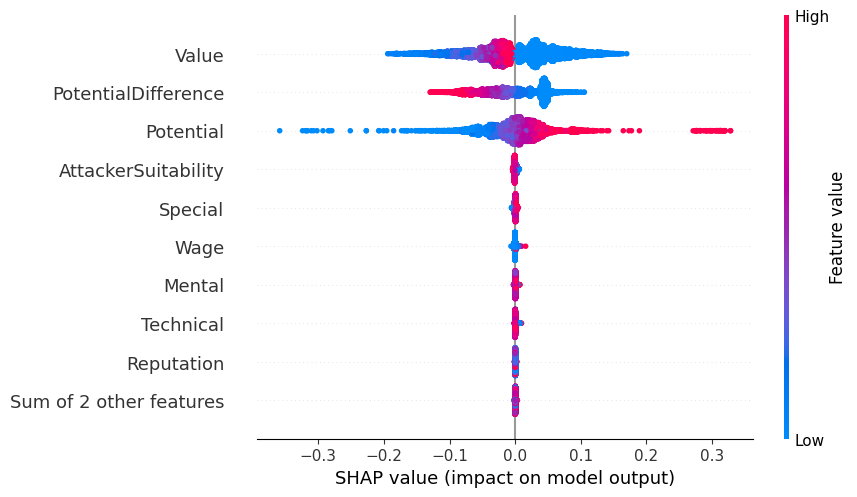

In [ ]:
# Assuming the best model from Approach 1 is already trained
best_model_task1 = model_XGB_1

# Create the SHAP explainer
explainer = shap.Explainer(best_model_task1)
shap_values = explainer(X_test_best)

shap.plots.beeswarm(shap_values)

## **Task 2 - Predicting Players' Best Position**

In this task, we aim to classify players into their best playing positions using various machine learning models. The classification task involves analyzing player attributes to determine their most suitable position on the field.

We focused on three models: Decision Tree, Random Forest, and XGBoost, evaluating their performance using metrics such as precision, recall, F1-score, and support.
Our approach included generalizing similar positions to balance the dataset.

The goal is to identify which model performs best in predicting player positions and understand the challenges in classifying certain positions.

### Data Preparation

**Initial Analysis**

In [ ]:
print(f"The following positions exist:\n{df_fifa['Best Position'].unique()}" )

The following positions exist:
['LWB' 'CAM' 'CM' 'GK' 'ST' 'CB' 'RW' 'CDM' 'CF' 'LB' 'RB' 'RWB' 'LM' 'RM'
 'LW' 'SW' 'LF']


**Best Position Distribution - Origin**

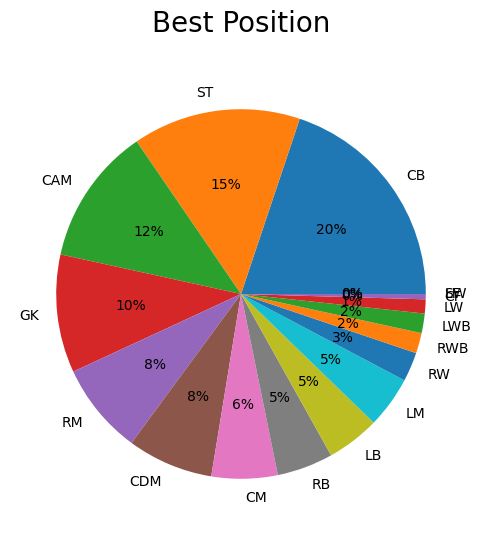

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
df_fifa['Best Position'].value_counts().plot.pie(
    autopct='%1.0f%%',
    radius=1,
    ax=ax,
    ylabel=''
)

plt.title('Best Position', y=1.05, fontsize=20)
plt.show()

**Best Position - Generalize**

We can see that there is imbalance and we want to generalize the position
to get more balanced data

In [ ]:
# generalize positions
df_normalized.loc[df_normalized['Best Position'].isin(('LF','CF', 'ST')),'Best Position'] = 'ST'
df_normalized.loc[df_normalized['Best Position'].isin(('LW', 'RW', 'LM', 'RM')),'Best Position'] = 'WI'
df_normalized.loc[df_normalized['Best Position'].isin(('RB', 'LB', 'RWB', 'LWB')),'Best Position'] = 'FB'

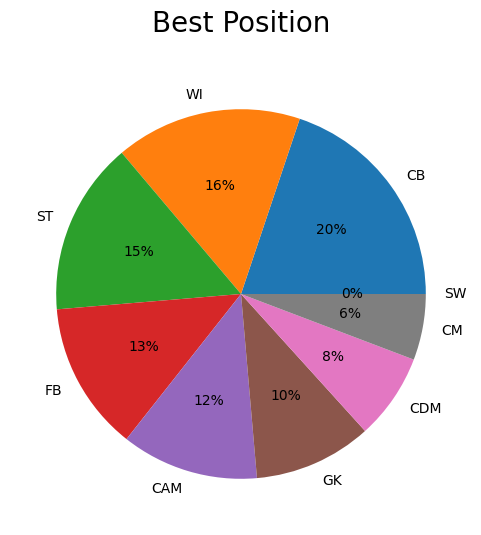

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
df_normalized['Best Position'].value_counts().plot.pie(
    autopct='%1.0f%%',
    radius=1,
    ax=ax,
    ylabel=''
)

plt.title('Best Position', y=1.05, fontsize=20)
plt.show()

#### **Feature Selection**

In [ ]:
numerical_cols = df_normalized.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_cols)

['ID', 'Age', 'Overall', 'Potential', 'Value', 'Wage', 'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Overall Rating', 'Year', 'Attack_Work_Rate', 'Defend_Work_Rate', 'Body Type_Lean', 'Body Type_Normal', 'Body Type_Stocky', 'Body Type_Unique', 'BMI', 'Physical', 'Technical', 'Mental', 'AttackerSuitability', 'PotentialDifference', 'Reputation', 'GKSkills', 'Overall_Diff']


In [ ]:
# we dont want to use the following to predict the position
to_drop_for_classification = ['ID', 'Name', 'Nationality', 'Position', 'AgeGroup','Best Overall Rating', 'Overall_Diff']
df_fifa_q2 =df_normalized.drop(columns=to_drop_for_classification, inplace=False)
df_fifa_q2.head()

,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,...,Body Type_Stocky,Body Type_Unique,BMI,Physical,Technical,Mental,AttackerSuitability,PotentialDifference,Reputation,GKSkills
72331,0.461538,0.621212,0.543860,0.641026,0.007368,0.763780,0.0,0.25,0.50,0.25,...,0.0,0.0,0.517184,0.697059,0.699531,0.753136,0.696884,0.037037,0.333333,0.113082
2574,0.512821,0.621212,0.543860,0.358974,0.006316,0.725534,1.0,0.00,0.50,0.50,...,0.0,0.0,0.625454,0.561765,0.711268,0.777487,0.708215,0.037037,0.333333,0.113082
19899,0.538462,0.636364,0.561404,0.589744,0.008421,0.732846,1.0,0.00,0.75,0.50,...,0.0,0.0,0.588411,0.550000,0.715962,0.811518,0.728045,0.037037,0.416667,0.113082
37435,0.564103,0.651515,0.578947,0.615385,0.007368,0.750844,1.0,0.00,0.75,0.50,...,0.0,0.0,0.588411,0.511765,0.718310,0.819372,0.736544,0.037037,0.416667,0.113082
55521,0.564103,0.651515,0.578947,0.615385,0.007368,0.750844,1.0,0.00,0.75,0.50,...,0.0,0.0,0.588411,0.511765,0.718310,0.819372,0.736544,0.037037,0.416667,0.113082


#### **Split to Train & Test**

In [ ]:
train_df = df_fifa_q2[df_fifa_q2['Year']!= 2022]
test_df = df_fifa_q2[df_fifa_q2['Year']== 2022]

# Drop the 'Year' column from train and test sets
train_df = train_df.drop(columns=['Year'])
test_df = test_df.drop(columns=['Year'])

y_train = train_df['Best Position']
y_test = test_df['Best Position']
x_train = train_df.drop(columns='Best Position')
x_test = test_df.drop(columns='Best Position')
print(f"x train shape : {x_train.shape}" )
print(f"y train shape : {y_train.shape}" )
print(f"x test shape : {x_test.shape}")
print(f"y test shape : {y_test.shape}")

x train shape : (87551, 59)
y train shape : (87551,)
x test shape : (16567, 59)
y test shape : (16567,)


In [ ]:
# make sure all columns are set with float as dtype
for column in x_train.columns:
    if x_train[column].dtype != 'float64':
        raise TypeError(f"Column {column} is not of type float64. Actual type: {x_train[column].dtype}")

### Models and Evaluation
---

 **In order to predict the players' best poistion, we experimened with the following models:**
1. Decision Tree
2. Random Forest
3. XGBoost

---

Our approach included generalizing similar positions to balance the dataset and evaluating model performance.

---

**For evaluation, we will use the confusion matrix and classification report with the following measures:**

* **Precision**: The proportion of true positive predictions among all positive predictions made by the model, indicating the accuracy of positive predictions.

* **Recall**: The proportion of true positive predictions among all actual positive instances, indicating the model's ability to identify all positive instances.

* **F1-score:** The harmonic mean of precision and recall, providing a balanced measure of a model's accuracy that accounts for both false positives and false negatives.

* **Support:** The number of actual occurrences of each class in the dataset, used to provide context for the precision, recall, and F1-score metrics.

* **Macro F1:** The "macro" average in the F1 score refers to the arithmetic mean of the F1 scores calculated for each class independently.
It treats each class equally, regardless of its size.

### Model 1 - Decision Tree

#### Model 1 - Train

In [ ]:
start_time = time.time()

model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=10)
model.fit(x_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Training time: 2.233712911605835 seconds


In [ ]:
y_pred = model.predict(x_test)

#### Model 1 - Evaluation

In [ ]:
print(f"Macro F1-score of Decision Tree is: {f1_score(y_test, y_pred, average='macro'):.2f}")

Macro F1-score of Decision Tree is: 0.75


<Figure size 1000x1000 with 0 Axes>

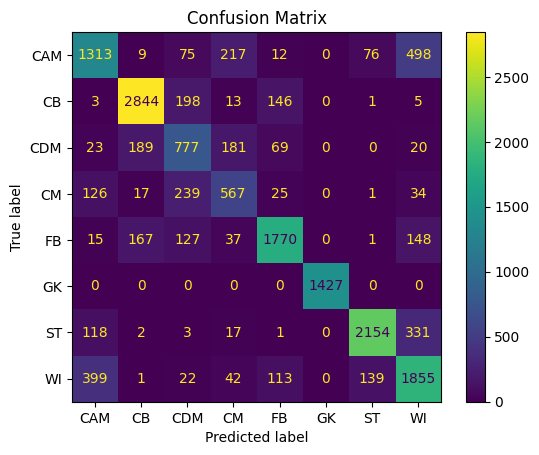

In [ ]:
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get the sorted unique labels
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Convert the confusion matrix to a pandas DataFrame
cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

# Display the DataFrame
print(cm_df)

      CAM    CB  CDM   CM    FB    GK    ST    WI
CAM  1313     9   75  217    12     0    76   498
CB      3  2844  198   13   146     0     1     5
CDM    23   189  777  181    69     0     0    20
CM    126    17  239  567    25     0     1    34
FB     15   167  127   37  1770     0     1   148
GK      0     0    0    0     0  1427     0     0
ST    118     2    3   17     1     0  2154   331
WI    399     1   22   42   113     0   139  1855


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         CAM       0.66      0.60      0.63      2200
          CB       0.88      0.89      0.88      3210
         CDM       0.54      0.62      0.58      1259
          CM       0.53      0.56      0.54      1009
          FB       0.83      0.78      0.80      2265
          GK       1.00      1.00      1.00      1427
          ST       0.91      0.82      0.86      2626
          WI       0.64      0.72      0.68      2571

    accuracy                           0.77     16567
   macro avg       0.75      0.75      0.75     16567
weighted avg       0.77      0.77      0.77     16567



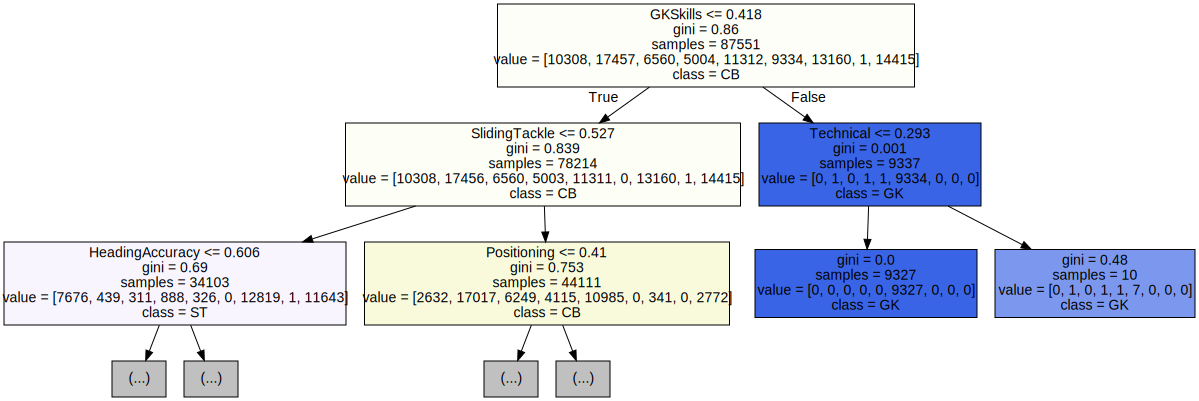

In [ ]:
dot_data = export_graphviz(model, out_file=None,
                                max_depth=2,
                                feature_names=model.feature_names_in_,
                                class_names=model.classes_,
                                filled=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
# Save the graph as a PNG image
graph.render(filename='decision_tree', format='png', cleanup=True)

'decision_tree.png'

**Try different depths:**

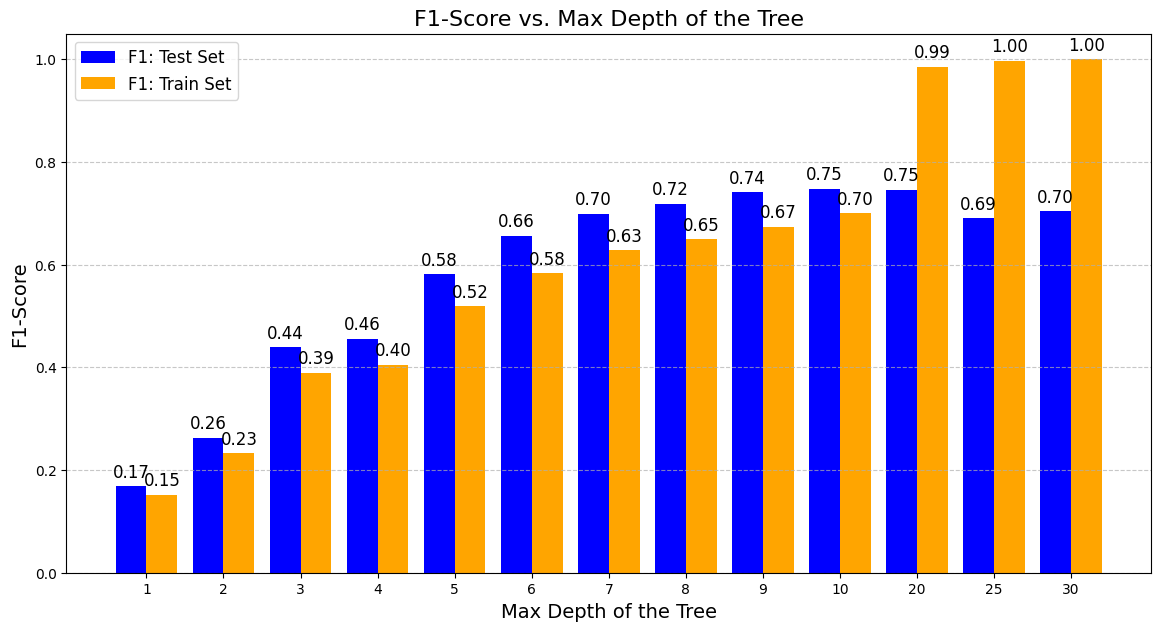

In [ ]:
scores = []
depths_list = [1,2,3,4,5,6,7,8,9,10,20,25,30]
scores = []
scores_train = []
for depth in depths_list:
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(x_train, y_train)
    predictions_train = model.predict(x_train)
    F1_train = f1_score(y_train, predictions_train, average='macro')
    scores_train.append(F1_train)
    predictions = model.predict(x_test)
    F1 = f1_score(y_test, predictions, average='macro')
    scores.append(F1)


bar_width = 0.4
x = np.arange(len(depths_list))
plt.figure(figsize=(14, 7))
plt.bar(x - bar_width/2, scores, width=bar_width, label='F1: Test Set', color='blue')
plt.bar(x + bar_width/2, scores_train, width=bar_width, label='F1: Train Set', color='orange')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
for i in range(len(depths_list)):
    plt.text(x[i] - bar_width/2, scores[i] + 0.01, f'{scores[i]:.2f}', ha='center', va='bottom', fontsize=12)
    plt.text(x[i] + bar_width/2, scores_train[i] + 0.01, f'{scores_train[i]:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('F1-Score vs. Max Depth of the Tree', fontsize=16)
plt.xlabel('Max Depth of the Tree', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(x, depths_list)
plt.legend(loc='best', fontsize=12)
plt.show()

### Model 2 - Random Forest

#### Model 2 - Train

In [ ]:
start_time = time.time()

model = RandomForestClassifier(n_estimators=50, criterion='entropy',max_depth=10)
model.fit(x_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Training time: 9.47883129119873 seconds


#### Model 2 - Evaluation

In [ ]:
y_pred = model.predict(x_test)
print(f'Macro F1-score of random forest is: {f1_score(y_test, y_pred, average="macro"):.2f}')

Macro F1-score of random forest is: 0.80


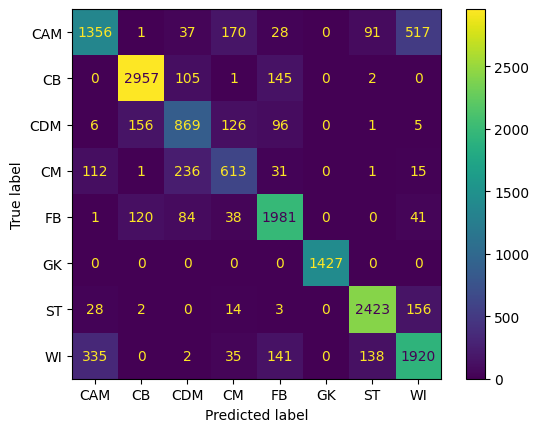

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
# Get the sorted unique labels
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Convert the confusion matrix to a pandas DataFrame
cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

# Display the DataFrame
print(cm_df)

      CAM    CB  CDM   CM    FB    GK    ST    WI
CAM  1356     1   37  170    28     0    91   517
CB      0  2957  105    1   145     0     2     0
CDM     6   156  869  126    96     0     1     5
CM    112     1  236  613    31     0     1    15
FB      1   120   84   38  1981     0     0    41
GK      0     0    0    0     0  1427     0     0
ST     28     2    0   14     3     0  2423   156
WI    335     0    2   35   141     0   138  1920


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         CAM       0.74      0.62      0.67      2200
          CB       0.91      0.92      0.92      3210
         CDM       0.65      0.69      0.67      1259
          CM       0.61      0.61      0.61      1009
          FB       0.82      0.87      0.84      2265
          GK       1.00      1.00      1.00      1427
          ST       0.91      0.92      0.92      2626
          WI       0.72      0.75      0.73      2571

    accuracy                           0.82     16567
   macro avg       0.80      0.80      0.80     16567
weighted avg       0.82      0.82      0.82     16567



**Try different estimators:**

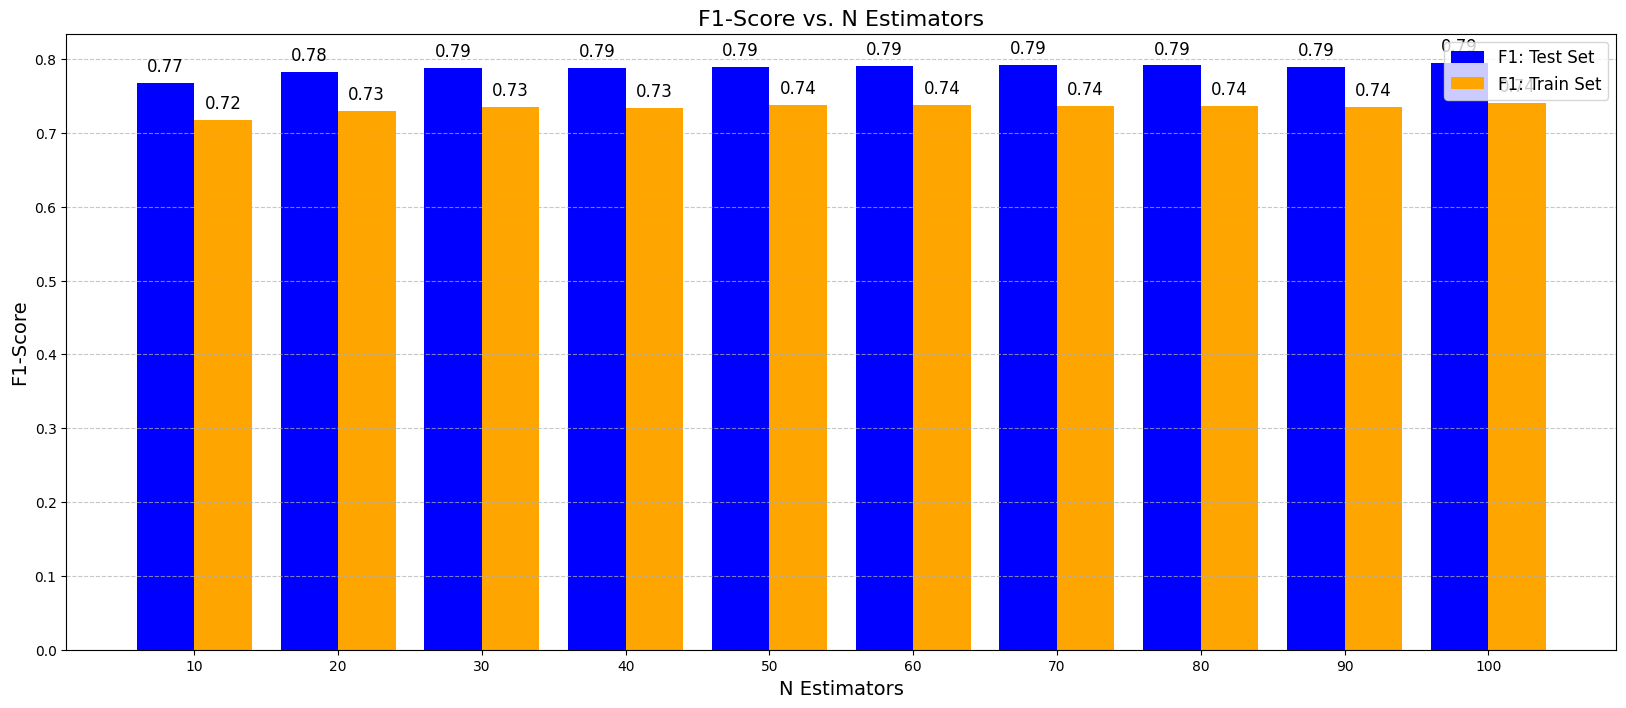

In [ ]:
scores = []
n_estimators = np.arange(start=10, stop=101, step=10)
scores = []
scores_train = []
for n_estimator in n_estimators:
    model = RandomForestClassifier(n_estimators=n_estimator, max_depth=10)
    model.fit(x_train, y_train)
    predictions_train = model.predict(x_train)
    F1_train = f1_score(y_train, predictions_train, average='macro')
    scores_train.append(F1_train)
    predictions = model.predict(x_test)
    F1 = f1_score(y_test, predictions, average='macro')
    scores.append(F1)

bar_width = 0.4
x = np.arange(len(n_estimators))
plt.figure(figsize=(20, 8))
plt.bar(x - bar_width/2, scores, width=bar_width, label='F1: Test Set', color='blue')
plt.bar(x + bar_width/2, scores_train, width=bar_width, label='F1: Train Set', color='orange')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
for i in range(len(n_estimators)):
    plt.text(x[i] - bar_width/2, scores[i] + 0.01, f'{scores[i]:.2f}', ha='center', va='bottom', fontsize=12)
    plt.text(x[i] + bar_width/2, scores_train[i] + 0.01, f'{scores_train[i]:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('F1-Score vs. N Estimators', fontsize=16)
plt.xlabel('N Estimators', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(x, n_estimators)
plt.legend(loc='best', fontsize=12)
plt.show()

### Model 3 - XGBoost

#### Model 3 - Train

In [ ]:
yoe = OrdinalEncoder().fit(y_train.values.reshape(-1,1))
yoe.transform(y_train.values.reshape(-1,1))
y_train_e, y_test_e = yoe.transform(y_train.values.reshape(-1,1)), yoe.transform(y_test.values.reshape(-1,1))

In [ ]:
start_time = time.time()

model = XGBClassifier(n_estimators=50, eval_metric=f1_score, device="cuda")
model.fit(x_train, y_train_e)

end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Training time: 12.091830968856812 seconds


#### Model 3 - Evaluation

In [ ]:
y_pred = model.predict(x_test)
print(f"Macro F1-score of XGBoost is: {f1_score(y_test_e, y_pred, average='macro'):.2f}")

Macro F1-score of XGBoost is: 0.86


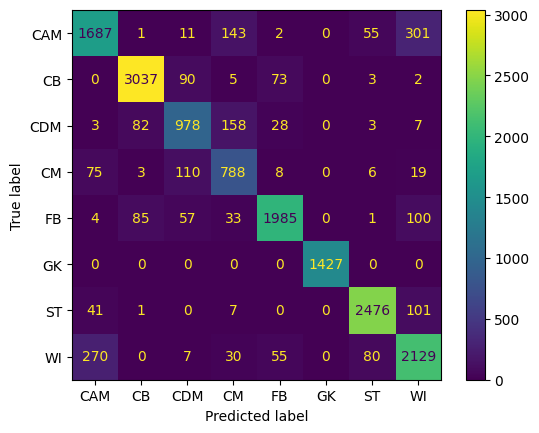

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, yoe.inverse_transform(y_pred.reshape(-1,1)))

In [ ]:
# Predict
y_pred_for_cm = y_pred.reshape(-1, 1)  # Ensure y_pred has the correct shape

# Generate the confusion matrix with all possible labels
all_labels = yoe.transform(yoe.categories_[0].reshape(-1, 1)).flatten()
cm = confusion_matrix(y_test_e, y_pred_for_cm, labels=all_labels)

# Convert the confusion matrix to a pandas DataFrame
cm_df = pd.DataFrame(cm, index=yoe.categories_[0], columns=yoe.categories_[0])

# Display the DataFrame
print(cm_df)


      CAM    CB  CDM   CM    FB    GK    ST  SW    WI
CAM  1687     1   11  143     2     0    55   0   301
CB      0  3037   90    5    73     0     3   0     2
CDM     3    82  978  158    28     0     3   0     7
CM     75     3  110  788     8     0     6   0    19
FB      4    85   57   33  1985     0     1   0   100
GK      0     0    0    0     0  1427     0   0     0
ST     41     1    0    7     0     0  2476   0   101
SW      0     0    0    0     0     0     0   0     0
WI    270     0    7   30    55     0    80   0  2129


In [ ]:
print(classification_report(y_test, yoe.inverse_transform(y_pred.reshape(-1,1))))

              precision    recall  f1-score   support

         CAM       0.81      0.77      0.79      2200
          CB       0.95      0.95      0.95      3210
         CDM       0.78      0.78      0.78      1259
          CM       0.68      0.78      0.73      1009
          FB       0.92      0.88      0.90      2265
          GK       1.00      1.00      1.00      1427
          ST       0.94      0.94      0.94      2626
          WI       0.80      0.83      0.81      2571

    accuracy                           0.88     16567
   macro avg       0.86      0.86      0.86     16567
weighted avg       0.88      0.88      0.88     16567



**Try different estimators:**

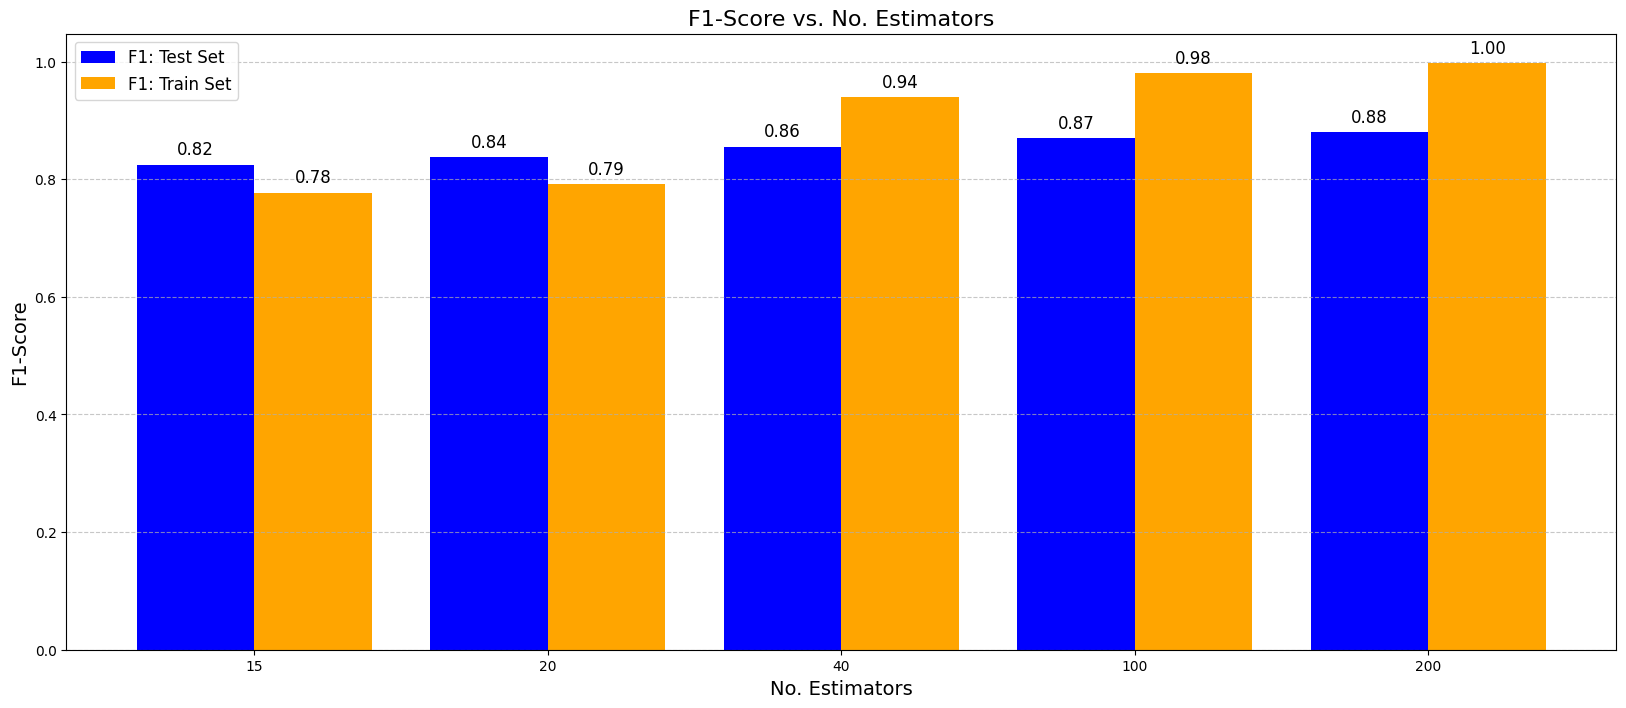

In [ ]:
scores = []
no_estimators = [15, 20, 40, 100, 200]
scores = []
scores_train = []
for no_estimator in no_estimators:
    model = XGBClassifier(n_estimators=no_estimator, device="cuda")
    model.fit(x_train, y_train_e)
    predictions_train = model.predict(x_train)
    F1_train = f1_score(y_train_e, predictions_train, average='macro')
    scores_train.append(F1_train)

    predictions = model.predict(x_test)
    F1 = f1_score(y_test_e, predictions, average='macro')
    scores.append(F1)

bar_width = 0.4
x = np.arange(len(no_estimators))
plt.figure(figsize=(20, 8))
plt.bar(x - bar_width/2, scores, width=bar_width, label='F1: Test Set', color='blue')
plt.bar(x + bar_width/2, scores_train, width=bar_width, label='F1: Train Set', color='orange')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
for i in range(len(no_estimators)):
    plt.text(x[i] - bar_width/2, scores[i] + 0.01, f'{scores[i]:.2f}', ha='center', va='bottom', fontsize=12)
    plt.text(x[i] + bar_width/2, scores_train[i] + 0.01, f'{scores_train[i]:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('F1-Score vs. No. Estimators', fontsize=16)
plt.xlabel('No. Estimators', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(x, no_estimators)
plt.legend(loc='best', fontsize=12)
plt.show()

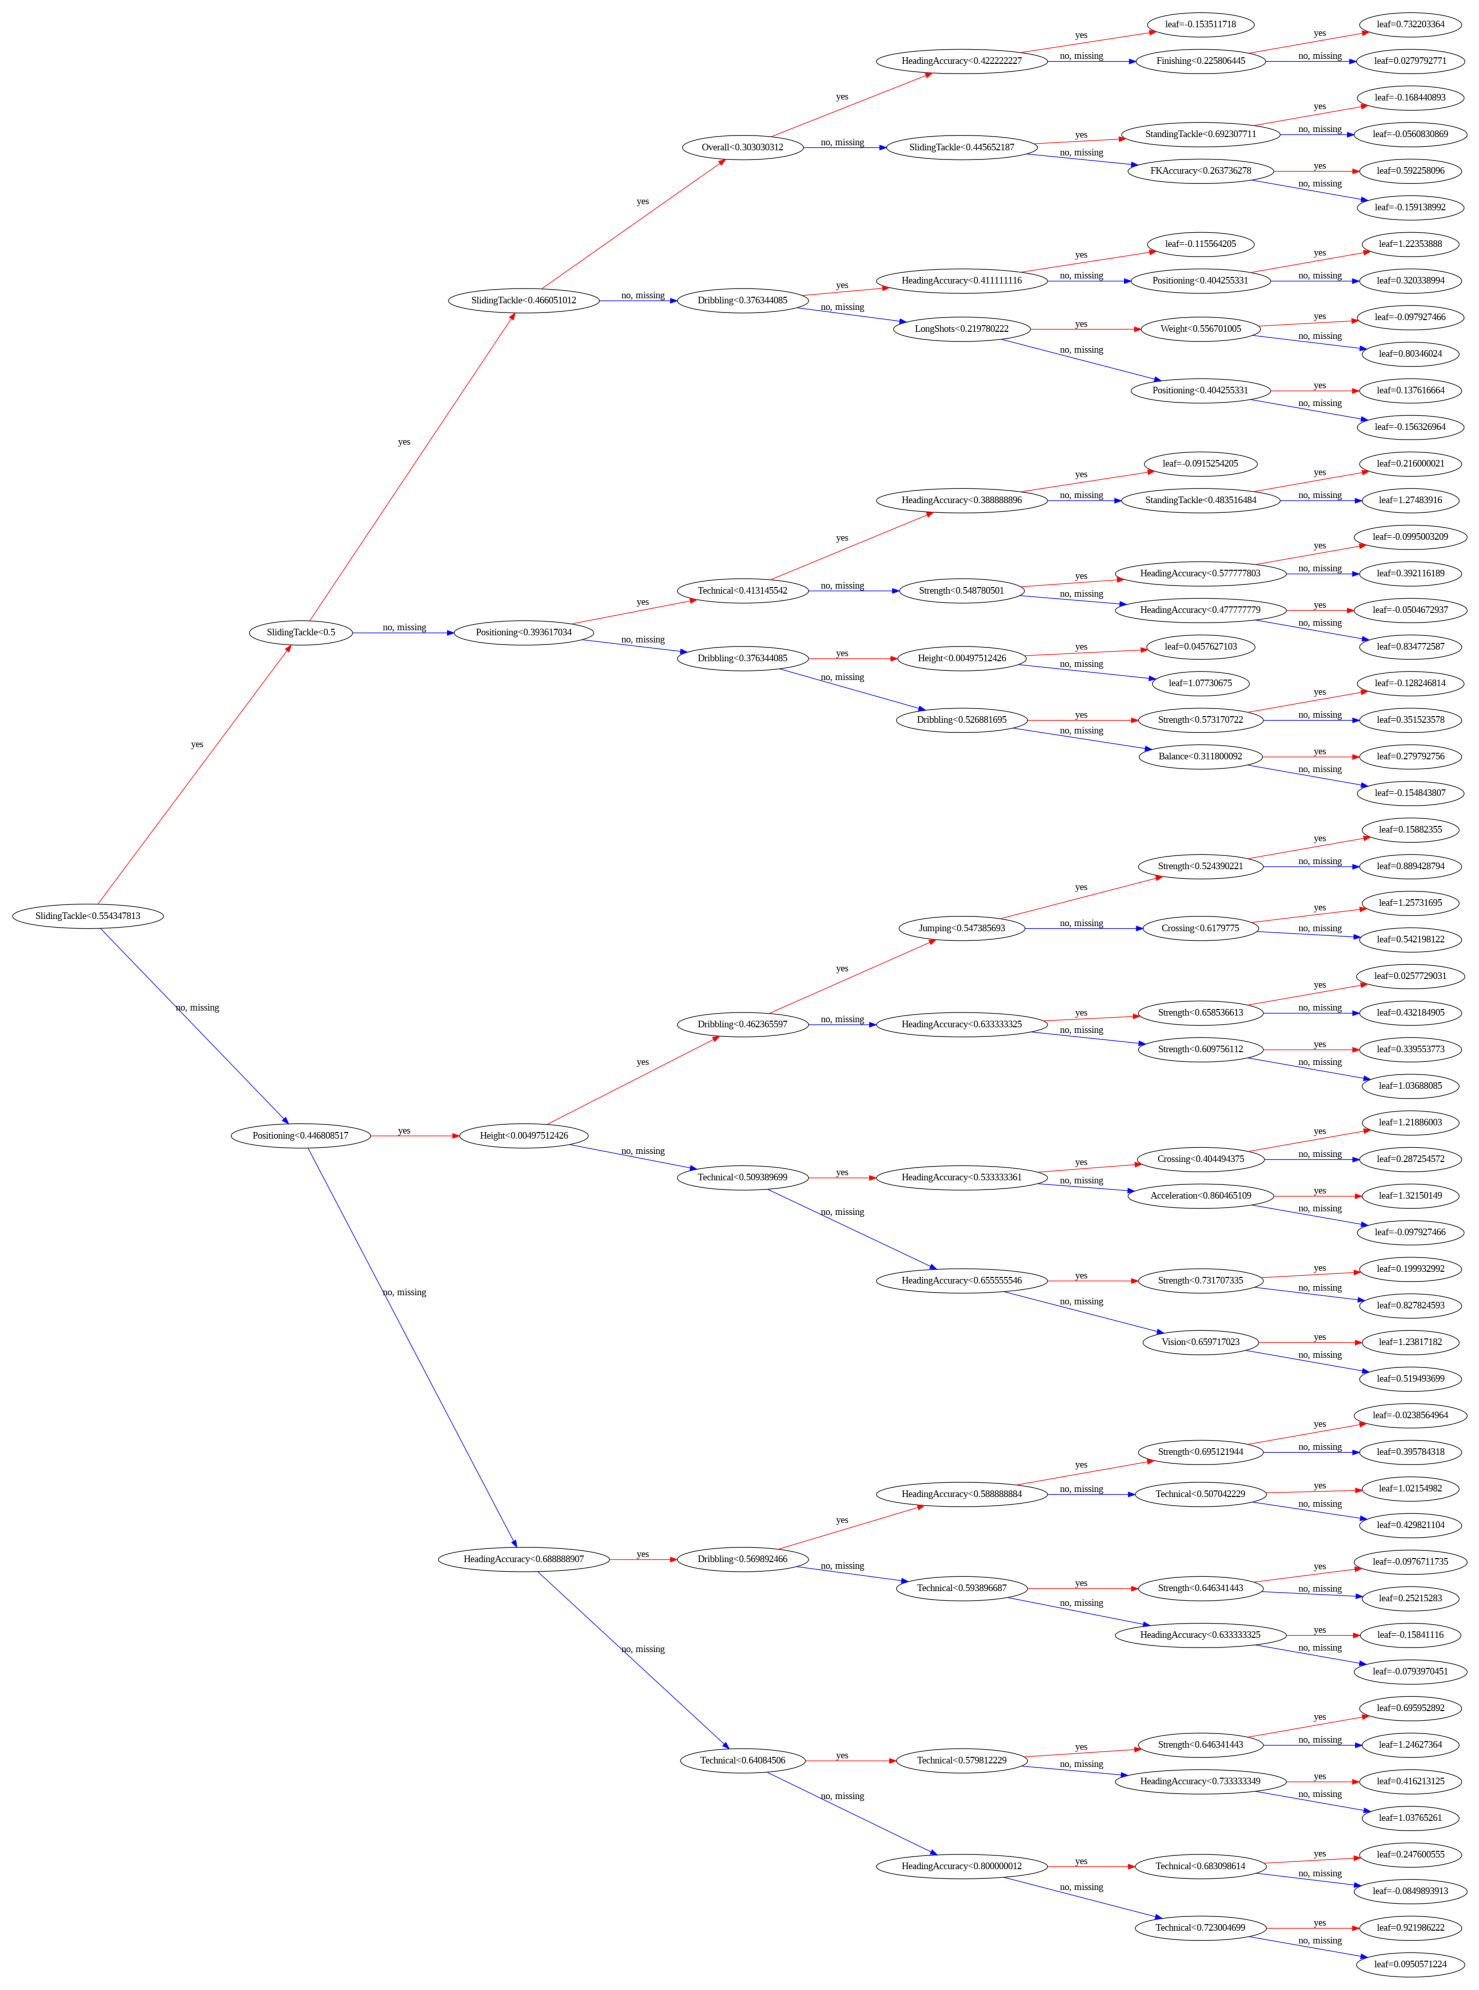

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
plot_tree(booster=model, num_trees=1, ax=ax, rankdir='LR')
plt.tight_layout()
plt.show()